# HPDM097: Foundations of combinatorial optimisation for routing and scheduling problems in health

Many healthcare systems manage assets or workforces that they need to deploy geographically. One example, is a community nursing team. These are teams of highly skilled nurses that must visit patients in their own home. Another example, is patient transport services where a fleet of non-emergency ambulances pick up patients from their own home and transport them to outpatient appointments in a clinical setting. These problems are highly complex. For example, in the community nursing example, patients will have a variety of conditions, treatments may be time dependent (for example, insulin injections), nurses will have mixed skills and staffing will vary over time.

---

# The Travelling Nurse Problem

For simplicity you will first consider a single asset that has to visit patients in their own home and ignore the complex constraints described above. We will frame this problem as the famous **Travelling Salesperson (or Nurse!) Problem (TSP).**

**By the end of this section you will have learnt how to:**

* represent a routing and scheduling problem in a form suitable for solution by an optimisation algorithm
* solve small instances of the Travelling Salesman Problem (TSP) using a brute force approach
* solve and obtain good solutions to larger TSP problem by applying hill climbing algorithms in combination with stochastic algorithms
* understand and apply a more intelligent hill climbing approach called Iterated Local Search

> Please use the conda environment `hds_logistics` when running this workbook.  You will also need to run this workbook in the same directory as `metapy`.  This is a small python package that contains the code to solve the TSP.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# `metapy` package imports

In [2]:
import metapy.tsp.tsp_io as io
import metapy.tsp.euclidean as e


from metapy.tsp.init_solutions import TSPPopulationGenerator

from metapy.tsp.objective import SimpleTSPObjective, OptimisedSimpleTSPObjective
from metapy.tsp.bruteforce import BruteForceSolver, RandomSearch

from metapy.local_search.ils import (IteratedLocalSearch,
                                     HigherQualityHomeBase,
                                     RandomHomeBase,
                                     EpsilonGreedyHomeBase,
                                     AnnealingEpsilonGreedyHomeBase,
                                     TempFastCoolingSchedule,
                                     DoubleBridgePertubation,
                                     TabuDoubleBridgeTweak)

from metapy.local_search.hill_climbing import (HillClimber,
                                               TweakTwoOpt, 
                                               SimpleTweak,
                                               HillClimberRandomRestarts)


from metapy.evolutionary.evolutionary import (EvolutionaryAlgorithm, 
                                              MuLambdaEvolutionStrategy, 
                                              MuPlusLambdaEvolutionStrategy, 
                                              GeneticAlgorithmStrategy,
                                              ElitistGeneticAlgorithmStrategy,
                                              TwoOptMutator, TwoCityMutator,
                                              TruncationSelector, 
                                              TournamentSelector, 
                                              PartiallyMappedCrossover)

# Load the data.

In this notebook, you will work with the famous **st70** problem from [TSPLib](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html).  

> You will move onto a real health service dataset in **part 2** where you will work with the a more complex variant of this problem for routing and scheduling with mutilple health service assets.

The data is located in `data/st70.tsp`.  The data format from TSPLib contains both metadata and 2D coordinates of 'cities'.  The files therefore need some minor preprocessing before they are usable.

> For efficiency you will work mainly with `numpy`.  It of course possible to use `pandas` for this type of problem, but you will pay a heavy price in terms of execution time!

In [3]:
#load file
file_path = "data/st70.tsp"

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)

#read the meta data
meta = io.read_meta_data(file_path, md_rows)

#should be an numpy.ndarray
print(type(cities))

# should be 70 cities
print(cities.shape)

#print first 2 coordinate pairs
print(cities[:2])

print("st70 meta data")
print(meta)

<class 'numpy.ndarray'>
(70, 2)
[[64. 96.]
 [80. 39.]]
st70 meta data
['NAME: st70', 'TYPE: TSP', 'COMMENT: 70-city problem (Smith/Thompson)', 'DIMENSION: 70', 'EDGE_WEIGHT_TYPE : EUC_2D']


The meta data confirms that problem is Euclidean 2D.  This means that we need to calculate the euclidean distance between points.

In [4]:
#example of calculating a single euclidean distance
e.euclidean_distance(cities[0], cities[1])

59.20304046246274

In [5]:
from decimal import Decimal, ROUND_HALF_UP

def gen_matrix(cities, as_integer=False):
    """
    Creates a numpy array of euclidian distances between 2 sets of
    cities
    
    Parameters:
    ----------
    points: numpy.array
        coordinate pairs
    
    as_integers: bool, optional (default=False)
        If true then round to nearest int.
        Behaviour: 1.5 -> 2
                   1.2 -> 1
                   1.8 -> 2
                   
    Returns:
    -------
        np.ndarray
            Matrix of city to city costs
    
    """
    size = len(cities)
    matrix = np.zeros(shape=(size, size))
    
    row = 0
    col = 0
    
    for city1 in cities:
        col = 0
        for city2 in cities:
            distance = e.euclidean_distance(city1, city2)
            if as_integer:
                distance = int(Decimal(distance).quantize(0, ROUND_HALF_UP))
            matrix[row, col] = distance
            col+=1
        row +=1
        
    return matrix

In [6]:
#generate matrix
matrix = gen_matrix(cities, as_integer=True)

file_out = 'data/st70_matrix.csv'

#output city matrix - to validate and use for manual calcs etc.
np.savetxt(file_out, matrix, delimiter=",")

In [7]:
matrix.shape

(70, 70)

# Representation

While you develop your code it is recommended that you work with a small tour.  This means that you can find the optimal solution by enumerating all solutions and check that your algorithm is working.

Representation is straightforward in TSP.  It is recommended that create a `np.ndarray` as a vector of city indexes.  For example in a TSP problem with 8 cities.

In [8]:
#create ordered list of cities to visit
tour = np.arange(8)
tour

array([0, 1, 2, 3, 4, 5, 6, 7])

> Remember that the TSP is a loop.  You need to remember this when calculating the tour length

# Calculating the length of a tour

In [9]:
objective = SimpleTSPObjective(matrix)
objective.evaluate(tour)

280.0

In [10]:
rng = np.random.default_rng(seed=42)
tour = np.arange(8)
rng.shuffle(tour)
tour

array([3, 4, 2, 7, 6, 1, 5, 0])

In [11]:
objective.evaluate(tour)

248.0

In [12]:
objective2 = OptimisedSimpleTSPObjective(matrix)
objective2.evaluate(tour)

248.0

In [13]:
%timeit objective.evaluate(tour)

100000 loops, best of 5: 4.24 µs per loop


In [14]:
%timeit objective2.evaluate(tour)

The slowest run took 19.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.94 µs per loop


# Visualising a tour

A simple way to visualise a tour is to use matplotlib.  The function `plot_tour` below has been provided to help you visualise a single tour.

Run the code below.  It should be easy to see that this isn't a very sensible tour if your objective is to simply minimise travel distance!

In [54]:
def plot_tour(tour, cities, figsize=(6,4)):
    '''
    Plots a tour.  Each city visited is
    labelled in order.  Red point is the initial city.
    
    Params:
    ------
    tour: np.ndarray
        ordered vector representing tour e.g. [1, 4, 2, 3]
        
    cities: np.ndarray
        matrix representing city coordinates
        
    figsize: tuple, optional (default = (6,3))
        tuple of ints for figure size
        
    Returns
    -------
        tuple of matplotlib figure, and axis
    '''

    tour_length = len(tour)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #plot points
    ax.plot(cities[:tour_length][:, 0],
            cities[:tour_length][:, 1],'bo')

    #plot lines
    for j in range(len(tour)-1):
        city_1 = tour[j]
        city_2 = tour[j+1]

        #lookup coordinates
        coords_1 = cities[city_1]
        coords_2 = cities[city_2]
        coords = np.vstack([coords_1, coords_2])

        #plot lines
        ax.plot(coords[:,0], coords[:,1], 'g-')
        
        #show order in tour
        ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(j))

    #add in loop back colour code in red...
    city_1 = tour[-1]
    city_2 = tour[0]

    coords_1 = cities[city_1]
    coords_2 = cities[city_2]
    coords = np.vstack([coords_1, coords_2])
    ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(tour_length-1))
    ax.plot(coords[:,0], coords[:,1], 'r--')
        
    return fig, ax

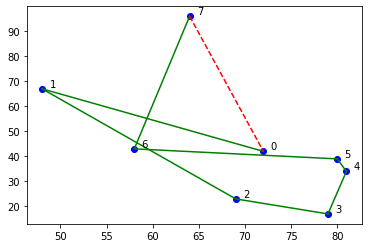

In [16]:
#example visualising a tour
rng = np.random.default_rng(seed=42)
tour = np.arange(8)
rng.shuffle(tour)

#plot the tour
fig, ax = plot_tour(tour, cities)

# Enumerating all solutions

You can enumerate all solutions of a **small** TSP using the `metapy.tsp.bruteforce.BruteForceSolver` class.  The code below creates a `solver` passes in a initial solution (a tour) and a `objective` and then runs the solver. 

The function `print_output` has been provided so that you can quickly output the results of the solver.


In [17]:
def print_output(solver):
    '''
    Utility function for printing formatted output of a solver
    
    Params:
    -------
    solver: object
        Solver class that has .best_solutions, .best_cost attributes
    '''
    print("\nbest solutions:\t{0}".format(len(solver.best_solutions)))
    print("best cost:\t{0}".format(solver.best_cost))
    print("best solutions:")
    [print(s) for s in solver.best_solutions]

In [18]:
#create a tour - there is NO need to randomise for bruteforce
tour = np.arange(8)

#create the objective 
objective = SimpleTSPObjective(matrix)

#create the brute force solver
solver = BruteForceSolver(tour, objective)

#run the solver (should be quick below tour of length 10)
print("Enumerating all solutions...")
solver.solve()
print("\n** BRUTEFORCE OUTPUT ***")

#this should find two optimal solutions! (the reverse of each other)
print_output(solver)

Enumerating all solutions...

** BRUTEFORCE OUTPUT ***

best solutions:	2
best cost:	180.0
best solutions:
[0 3 1 6 7 2 5 4]
[0 4 5 2 7 6 1 3]


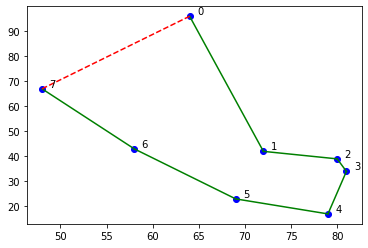

In [19]:
#now visualise the result of solution 1
fig, ax = plot_tour(solver.best_solutions[0], cities)

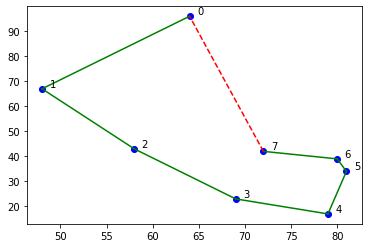

In [20]:
#now visualise the results of solution 2 (the reverse of 1)
fig, ax = plot_tour(solver.best_solutions[1], cities)

# Exercise 1: Solving a 9 city TSP

**Task**:
* Use a brute force approach to solve a 9 city TSP from the st70 dataset
* Plot the results


    

In [21]:
# your code here...

In [22]:
#example solution

#create a tour - there is NO need to randomise for bruteforce
tour = np.arange(9)

#create the objective 
objective = SimpleTSPObjective(matrix)

#create the brute force solver
solver = BruteForceSolver(tour, objective)

#run the solver (should be quick below tour of length 10)
print("Enumerating all solutions...")
solver.solve()
print("\n** BRUTEFORCE OUTPUT ***")

#this should find two optimal solutions! (the reverse of each other)
print_output(solver)

Enumerating all solutions...

** BRUTEFORCE OUTPUT ***

best solutions:	4
best cost:	230.0
best solutions:
[0 3 1 6 7 2 8 5 4]
[0 4 5 8 2 7 6 1 3]
[0 4 8 2 7 6 1 3 5]
[0 5 3 1 6 7 2 8 4]


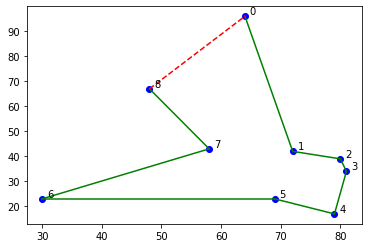

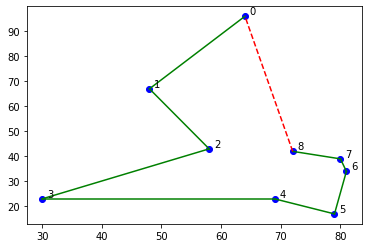

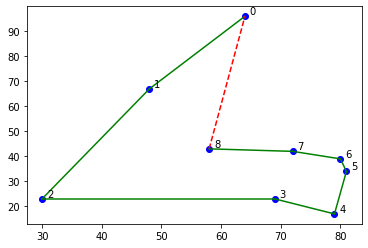

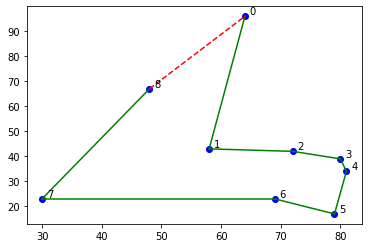

In [23]:
for i in range(4):
    plot_tour(solver.best_solutions[i], cities)

# A basic optimisation method: random search

Instead of a brute force enumeration we could have solved the small TSP problem using a **global optimisation algorithm**.  These algorithms do not get stuck in 'local optima' and will find the optimum solution **if run for long enough**.  That is a big **IF**!

The simplest method is **random search**.  This makes *b* shuffles of the tour where *b* is an fixed iteration budget or the number of iterations that can be complete in a specified time limit.  

> Random search is straightforward to implement yourself. It is a loop with a if statement checking for new best solutions.

You can also use `metapy.trp.bruteforce.RandomSearch` to conduct a random search on the TSP.  

```python
#note max_iter is an optional parameter with default value of 1000
solver = RandomSearch(tour, objective, max_iter=1000)
```

# Exercise 2: Setting a benchmark with random search

**Task**:
* Apply random search to the 9 city problem in the st70 dataset. Use a max_iter budget of 1000.
* Compare the result to the optimal solution obtained in exercise 1. 
* Set a benchmark for solving the 70 city problem - apply random search to the full 70 city problem

**Hints:**
* When using random search with the 9 city problem you may want to complete multiple runs to get a feel for its performance. 


In [24]:
# your code here ...

Running Random Search...

** RANDOM SEARCH OUTPUT ***

best solutions:	1
best cost:	230.0
best solutions:
[7 6 1 3 5 0 4 8 2]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f73167389b0>)

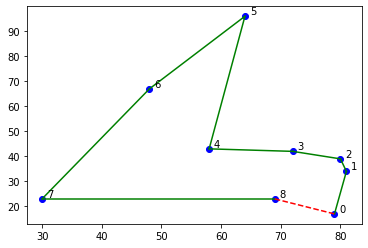

In [25]:
#example solution 9 city

#create a tour - there is NO need to randomise for bruteforce
tour = np.arange(9)

#create the objective 
objective = SimpleTSPObjective(matrix)

#create the random search solver
solver = RandomSearch(tour, objective, max_iter=5000, maximisation=False)

#run the solver (should be quick below tour of length 10)
print("Running Random Search...")
solver.solve()
print("\n** RANDOM SEARCH OUTPUT ***")

#this should find two optimal solutions! (the reverse of each other)
print_output(solver)
plot_tour(solver.best_solutions[0], cities)

Running Random Search on 70 cities...

** RANDOM SEARCH OUTPUT ***

best solutions:	1
best cost:	2970.0
best solutions:
[48 11 21 50 35 64 32 20 40 18 54 13 27 60 26  8  3 12 69 30 22 29 41 47
  6  2 52 43 19 58 14  9 55 45  5 31 57  0 36 15 68  1 39 62 46 33 42 44
 38 10 24 61 28 66 37 17 59 49  4 56 63 53  7 16 65 34 51 67 25 23]


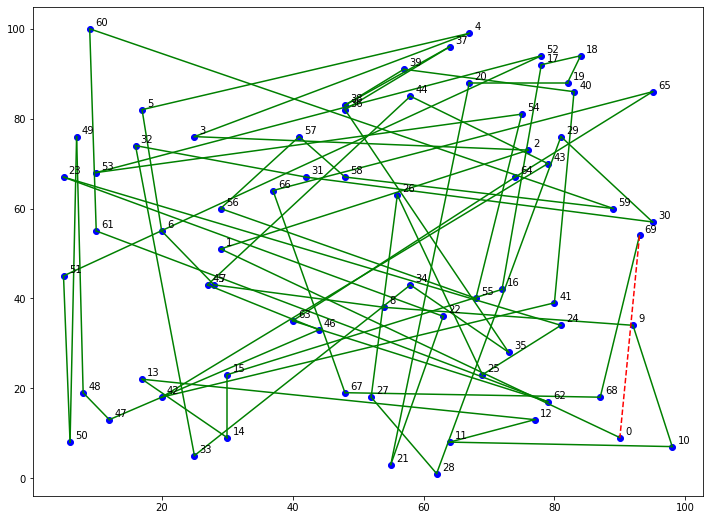

In [26]:
#example solution 70 city

#create a tour - there is NO need to randomise for bruteforce
tour = np.arange(70)

#create the objective 
objective = SimpleTSPObjective(matrix)

#create the random search solver
solver = RandomSearch(tour, objective, max_iter=10000, maximisation=False)

#run the solver (should be quick below tour of length 10)
print("Running Random Search on 70 cities...")
solver.solve()
print("\n** RANDOM SEARCH OUTPUT ***")

#show result
print_output(solver)

fig, ax = plot_tour(solver.best_solutions[0], cities, figsize=(12,9))

# Using a hill-climbing approach

When working in logistics it is likely that you will need to employ some form of simple hill-climbing algorithm.  These are very simple algorithms that iteratively test neighbouring solutions to see if they find any improvement.  This **local search** approach is often very successful at finding reasonably good solutions to a routing and scheduling problem. You will see that you can easily out perform random search. However, hill climbers do suffer from getting stuck in a **local optimum** and you can often do better by employing a more sophisticated algorithm.

**However,** you might be surprised at how useful hill-climbers turn out to be when used in combination with other approaches.  Here you will first experiment with a simple first improvement hill climber and then use it to **clean up** the solution produced by a evolutionary strategy and **combine** the framework into random search followed by hill climbing.  One of the key benefits of hill climbers is that they are relatively fast (because they are simple).  You can even set a time limit to get some of the benefit of local search without greatly extending the execution time of your algorithm.

> Although this the approach is called Hill-Climbing in the TSP you are **descending** a hill to the find the shortest route. The algorithm is the same, but you are maximising -1*objective (or alternatively $\dfrac{1}{objective}$).  


# Exercise 3: Simple versus 2-Opt tweaks

Hill-Climbing works by iteratively **tweaking** a solution to search for better neighbouring solutions. `metapy` provides two relatively straightforward tweak operators.  `SimpleTweak` swaps the position of two cities at a time while `TweakTwoOpt` reverses a section of the route between two cities.  Generally speaking `TweakTwoOpt` will produce better solutions, but it is worth considering a `SimpleTweak` approach when **cleaning up** the output of another algorithm.  You could also try both!

You create the tweak operators as follows:

```python
operator1 = SimpleTweak()
operator2 = TweakTwoOpt()
```
Each tweak operator provides a `tweak(tour, index1, index2)` method. **Note that the change to tour happens in place**

```python
tour = np.arange(10)
tweaker = SimpleTweak()
#swap cities at index 1 and index 2.
tweaker.tweak(tour, 1, 2)
```

**Task**:
* Create a numpy vector representing a tour of 10 cities 
* Perform a simple tweak of cities in elements 5 and 9
* Perform a 2-opt tweak between cities 1 and 4
* Print out the updated tour.


In [27]:
#your code here...

In [28]:
tour = np.arange(10)
tweaker1 = SimpleTweak()
tweaker1.tweak(tour, 5, 9)
tweaker2 = TweakTwoOpt()
tweaker2.tweak(tour, 1, 4)
tour

array([0, 3, 2, 1, 4, 9, 6, 7, 8, 5])

# Exercise 4: Hill-Climbing

You have been provided with a simple hill climber class in `metapy`.  The code below demonstrates how to create a hill-climbing object and run the algorithm.  

**Task:**
* Read the code below and check your understand it.
* Run the code below and check if the hill climber is better or worse than random search.
* Modify the code below so that you pass a random initial solution to the hill climber.

**Hints**:
* a random initial solution is just a **shuffled** numpy array.  



** Hill Climber First Improvement OUTPUT ***
best cost:	-710.0
best solutions:
[array([ 0, 35, 15, 46, 36, 57, 49, 52,  4,  9, 51, 50, 64, 63, 10, 55, 66,
       47, 53, 61, 32, 59, 11, 33, 20, 16, 42, 43, 67,  8, 39, 60, 38, 24,
       44, 45, 26, 29, 19, 13, 27, 48, 54, 25,  7,  2, 31, 41, 40,  5, 17,
        3,  1,  6, 18, 23, 14, 56, 62, 65, 21, 58, 37, 22, 28, 12, 30, 34,
       68, 69])]


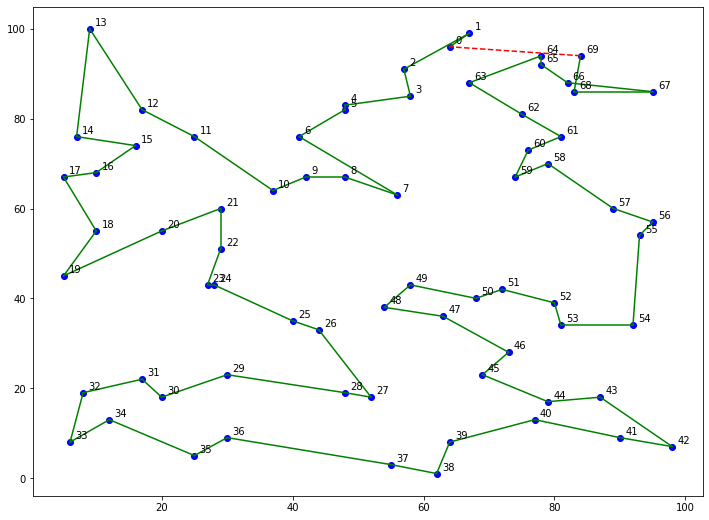

In [29]:
#Basic First Improvement Hill Climber

#create a tour (full 70 cities)
tour = np.arange(70)

###########################################
# MODIFY CODE HERE TO SHUFFLE tour
#
###########################################

#create TSP objective
objective = SimpleTSPObjective(matrix)

#create Hill climbing algorithm
solver = HillClimber(objective=objective, 
                     init_solution=tour, 
                     tweaker=TweakTwoOpt(), 
                     maximisation=False)

#run the local search
solver.solve()

#output results
print("\n** Hill Climber First Improvement OUTPUT ***")
print("best cost:\t{0}".format(solver.best_cost))
print("best solutions:")
print(solver.best_solutions)
fig, ax = plot_tour(solver.best_solutions[0], cities, figsize=(12,9))


** Hill Climber First Improvement OUTPUT ***
best cost:	-838.0
best solutions:
[array([63, 64, 55, 10, 47, 66, 53, 32, 11, 59, 51,  9,  4, 52,  5, 40, 42,
       16, 20, 33, 61, 38, 60, 39, 44, 24, 45, 26, 67, 43, 29, 19, 13, 27,
        7, 25, 48, 54, 18,  1,  6, 31,  2, 41, 17,  3, 23, 14, 56, 34, 68,
       30, 69, 12, 28, 35,  0, 15, 50, 49, 57, 36, 46, 22, 37, 58, 21, 62,
       65,  8])]


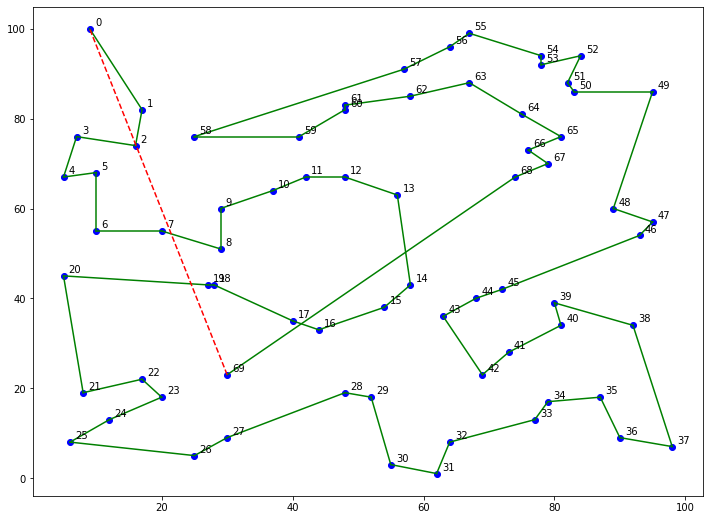

In [30]:
# Example solution.

#Basic First Improvement Hill Climber

#create a tour (full 70 cities)
tour = np.arange(70)

rng = np.random.default_rng(42)

#random init solution (operation in place)
rng.shuffle(tour)

#create TSP objective
objective = SimpleTSPObjective(matrix)

#create Hill climbing algorithm
solver = HillClimber(objective=objective, 
                     init_solution=tour, 
                     tweaker=TweakTwoOpt(), 
                     maximisation=False)

#run the local search
solver.solve()

#output results
print("\n** Hill Climber First Improvement OUTPUT ***")
print("best cost:\t{0}".format(solver.best_cost))
print("best solutions:")
print(solver.best_solutions)
fig, ax = plot_tour(solver.best_solutions[0], cities, figsize=(12,9))

# Exercise 5: Using an evolutionary algorithm followed by hill climbing

You will now experiment with using a hill climber to **clean up** the solution provided by a $(\mu, \lambda)$ evolutionary strategy.  It is often useful to make a few small computationally cheap tweaks to the solution provided by a more complex algorithm to gain additional performance.

The code below has been set up for you to run an evolutionary strategy againt the st70 problem.  

**Task:**
* Read and run the code.  Does the EA beat the basic hill climber and random search?  You may want to try this a few times or tune parameters.
* The final line of code assigns the EAs solution to `interim_solution`.  Create a `HillClimber` and pass in `interim_solution` as its initial solution.
* Try the `SimpleTweak()` operator.  
* Output the hill climbers results and plot the route.

**Hints**:
* The EA will take a few seconds to run. If you use new Jupyter cells for your hill climbing you can run each algorithm seperately.
* Remember the EA is stochastic.  Feel free to run it a few times to see how hill climbing can help.  It may not help every time.


Running (mu, lambda) evolutionary alg...

** (mu, LAMBDA) OUTPUT ***
best cost:	758.0
best solutions:
[57 36 46 15 22  0 35 12 28 69 34 30 68 37 58 21 62 65 52  4  9 51 50 63
 64 55 10 66 47 61 53 32 59 11 33 20 16 42 40  5 41 17  3  1 56 14 23 18
  6 31  2 43 67  8 39 60 38 44 24 45 26 29 19 13 27  7 48 54 25 49]
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.4 s


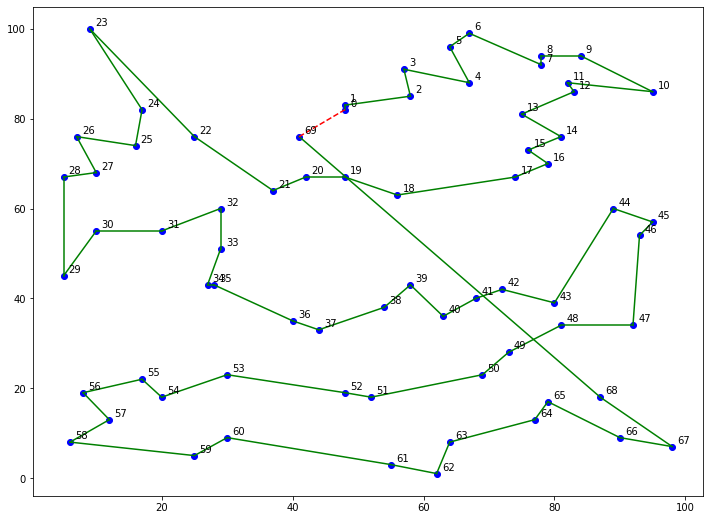

In [31]:
%%time

#Evolutionary Algorithm - (mu, lambda) strategy for TSP
mu = 10
_lambda = 200

#full tour
tour = np.arange(70)

###########################################################
# Create objective
# if you are finding EA a bit slow try OptimisedSimpleTSPObjective
# its experimental so be warned!
objective = SimpleTSPObjective(matrix)
#objective = OptimisedSimpleTSPObjective(matrix)
###########################################################

#create initial TSP population
init = TSPPopulationGenerator(tour)

#(Mu, Lambda) strategy using 2-Opt mutation
strategy = MuLambdaEvolutionStrategy(mu, _lambda, TwoOptMutator())

#EA 
solver = EvolutionaryAlgorithm(init, objective,_lambda, strategy, 
                               maximisation=False, generations=1000)

#run the EA
print("\nRunning (mu, lambda) evolutionary alg...")
solver.solve()

#output EA results
print("\n** (mu, LAMBDA) OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

interim_solution = solver.best_solution

#################################################
#
# Modification here: pass interim_solution to a hill climber
# or use a new Jupyter cell.
#
#################################################


Running (mu, lambda) evolutionary alg...

** (mu, LAMBDA) OUTPUT ***
best cost:	737.0
best solutions:
[64 50 55 66 10 47 53 61 32 59 11 33 20 16 42  8 39 60 38 24 44 45 26 67
 43 29 19 13 27 48 54 25  7  2 31 41 40  5 17  3  1  6 18 14 23 56 62 58
 37 21 65 52  4  9 51 49 36 57 46 22 15  0 35 28 12 69 34 68 30 63]

Running local search...

** Hill Climber First Improvement OUTPUT ***
best cost:	-727.0
best solutions:
[64 50 55 10 66 47 53 61 32 59 11 33 20 16 42  8 39 60 38 24 44 45 26 67
 43 29 19 13 27 48 54 25  7  2 31 41 40  5 17  3  1  6 18 23 14 56 62 58
 37 21 65 52  4  9 51 49 57 36 46 15 22  0 35 28 12 69 34 68 30 63]


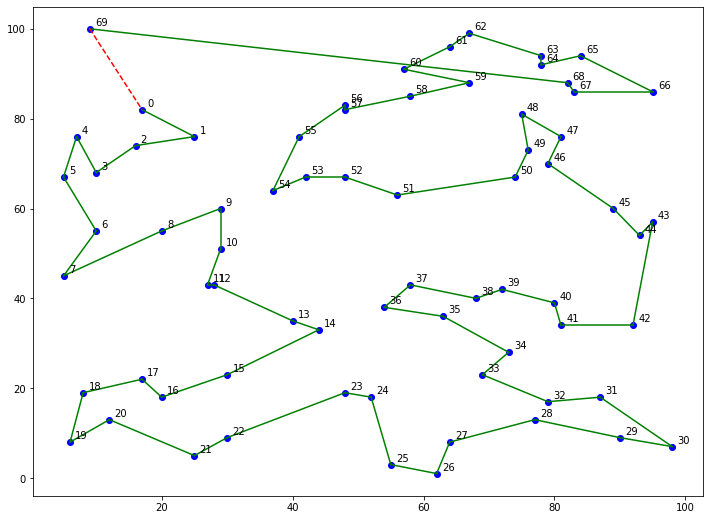

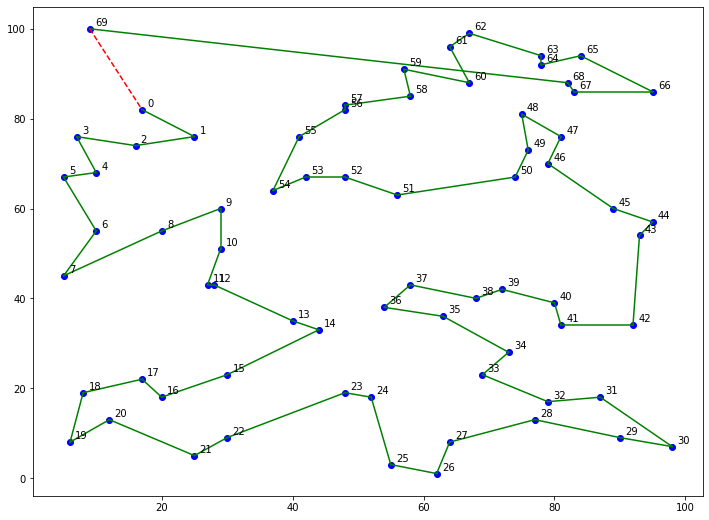

In [32]:
#Example solution

#Evolutionary Algorithm - (mu, lambda) strategy for TSP
mu = 10
_lambda = 200

#full tour
tour = np.arange(70)

#create objective
objective = SimpleTSPObjective(matrix)
objective = OptimisedSimpleTSPObjective(matrix)

#create initial TSP population
init = TSPPopulationGenerator(tour)

#(Mu, Lambda) strategy using 2-Opt mutation
strategy = MuLambdaEvolutionStrategy(mu, _lambda, TwoOptMutator())

#EA 
solver = EvolutionaryAlgorithm(init, objective,_lambda, strategy, 
                               maximisation=False, generations=1000)

#run the EA
print("\nRunning (mu, lambda) evolutionary alg...")
solver.solve()

#output EA results
print("\n** (mu, LAMBDA) OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

interim_solution = solver.best_solution

#now pass the solution to a simple hill climber with SimpleTweak
localsearch = HillClimber(objective, interim_solution, SimpleTweak(),
                          maximisation=False)

print("\nRunning local search...")
localsearch.solve()

print("\n** Hill Climber First Improvement OUTPUT ***")
print("best cost:\t{0}".format(localsearch.best_cost))
print("best solutions:")
print(localsearch.best_solutions[0])
fig, ax = plot_tour(localsearch.best_solutions[0], cities, figsize=(12,9))

# Exercise 6: Hill Climbing with Random Restarts

Hill-Climbing algorithms may provide a different local optima dependent on the initial solution it is provided.  One option is therefore to combine Random Search and Hill Climbing into a general (and still rather dumb) algorithm called Hill-Climbing with Random Restarts.  Effectively it runs Hill-Climbing multiple times with a new starting point each time.  The algorithm picks the best solution either as it executes or after it has completed.

**Task:**
* The code below allows you to run a `HillClimber` multiple times each time with a random initial solution.  
* Execute the code - how does it compare with the other procedures tested?
* Options:
    * Try `SimpleTweak()` instead of `TweakTwoOpt()`
    * Try a different `random_seed` or drop it?
    * Try a higher `max_iter` (remember this increased runtime!)



Running Hill-Climbing with Random Restarts...

** Hill Climbing with Random Restarts OUTPUT ***
best cost:	-710.0
best solutions:
[ 0 35 15 46 36 57 49 52  4  9 51 50 64 63 10 55 66 47 53 61 32 59 11 33
 20 16 42 43 67  8 39 60 38 24 44 45 26 29 19 13 27 48 54 25  7  2 31 41
 40  5 17  3  1  6 18 23 14 56 62 65 21 58 37 22 28 12 30 34 68 69]


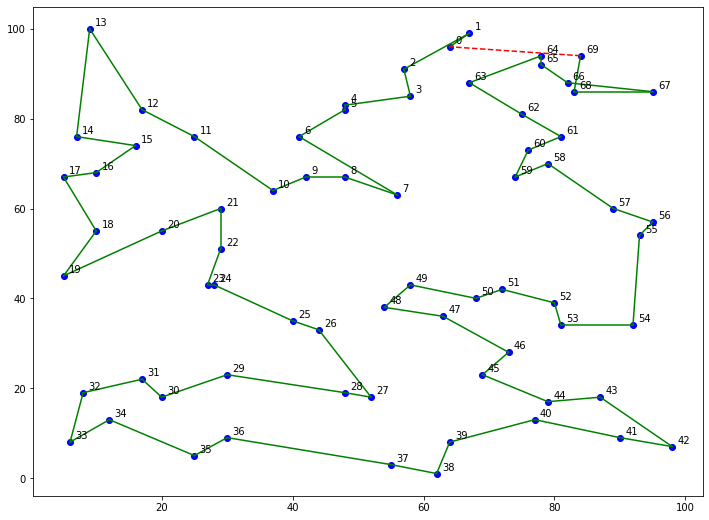

In [33]:
# Hill Climbing with random restarts

tour = np.arange(70)

objective = SimpleTSPObjective(matrix)

# basic first improvement hill climber
localsearch = HillClimber(objective, tour, TweakTwoOpt(),
                          maximisation=False)

#random restarts (multiple runs with random init solution)
solver = HillClimberRandomRestarts(objective, localsearch, tour, 
                                   maxiter=20, random_seed=101)

print("\nRunning Hill-Climbing with Random Restarts...")
solver.solve()

print("\n** Hill Climbing with Random Restarts OUTPUT ***")
print("best cost:\t{0}".format(solver.best_cost))
print("best solutions:")
print(solver.best_solutions[0])
fig, ax = plot_tour(solver.best_solutions[0], cities, figsize=(12,9))

# Exercise 7: Iterated Local Search

A more sophisticated version of Hill-Climbing with random restarts is **Iterated Local Search** or **ILS** for short.  

Instead of randomly restarting ILS defaults to a **homebase**.  A large tweak operation (called a pertubation!) is applied to the homebase and this is then used an the intial solution for Hill-Climbing.  There are a few more parameters/operators to tune with ILS and most important are deciding when to change homebase and what pertubation operator to use.  ILS can get quite creative in practice, but the psuedo code below gives the general appearance of the algorithm.


```
function iterated_local_search(init_solution)
    best = copy(init_solution)
    home = copy(init_solution)
    candidate = copy(init_solution)
    history = [home]

    while time_remains

        candidate = local_search(candidate)

        if quality(candidate) > quality(best)
            best = copy(candidate)
        end

        home = update_home(home, candidate)

        candidate, history = perturb(home, history)

    end

    return best
end

```

In the algorithm `history` is not always used.  If implemented, it essentially gives the algorithm a memory (or tabu list). It contains a list of previous initial solutions used in hill climbing and prevents the algorithm from repeating itself.  It usual to have a fixed sized memory (another hyper-parameter to tune!) 

The function `update_home` returns a homebase for perturbing.  Three simple implementations are a **random walk** and **greedy** and **epsilon greedy**.  A random walk uses the last local optima returned from hill climbing.  Greedy only accepts a new home base if the new local optima is better than the current homebase.  Finally, epsilon greedy takes a random walk epsilon of the time and acts greedy 1 - epsilon of the time.  A neat variation on epsilon greedy is to initially allow a lot of exploration and gradually decrease epsilon.  However, you will need more iterations (and longer execution time!) to get this to work in practice (but it may return better solutions to large problems).

The function `perturb` is essentially a tweak operator and hence tends to be problem specific.  In routing and scheduling problems (and particularly the TSP) a good operator is called the Double Bridge Tweak.  This breaks the tour into four parts, reverses and recombines.  You could combine with a tabu list if felt it was necessary.

**Task:**
* The code below illustrates how to use an implementation of ILS provided in `metapy`
* Your task to to experiment with ILS and compare how it performs to basic hill climbing with random restarts.
* There are several options you can use to experiment. Uncomment the lines of code to explore the different approaches.
    * updating the home base 
    * perturbing the home base 
    * the number of iterations of ILS


ITERATED LOCAL SEARCH
Initial solution cost: -3559.0

Running 30 iterations...
1: iteration cost: -830.0; homebase cost: -830.0; best found -830.0
2: iteration cost: -773.0; homebase cost: -773.0; best found -773.0
3: iteration cost: -832.0; homebase cost: -773.0; best found -773.0
4: iteration cost: -805.0; homebase cost: -773.0; best found -773.0
5: iteration cost: -805.0; homebase cost: -773.0; best found -773.0
6: iteration cost: -768.0; homebase cost: -768.0; best found -768.0
7: iteration cost: -777.0; homebase cost: -768.0; best found -768.0
8: iteration cost: -812.0; homebase cost: -768.0; best found -768.0
9: iteration cost: -769.0; homebase cost: -768.0; best found -768.0
10: iteration cost: -798.0; homebase cost: -768.0; best found -768.0
11: iteration cost: -850.0; homebase cost: -850.0; best found -768.0
12: iteration cost: -765.0; homebase cost: -765.0; best found -765.0
13: iteration cost: -782.0; homebase cost: -765.0; best found -765.0
14: iteration cost: -819.0; homeb

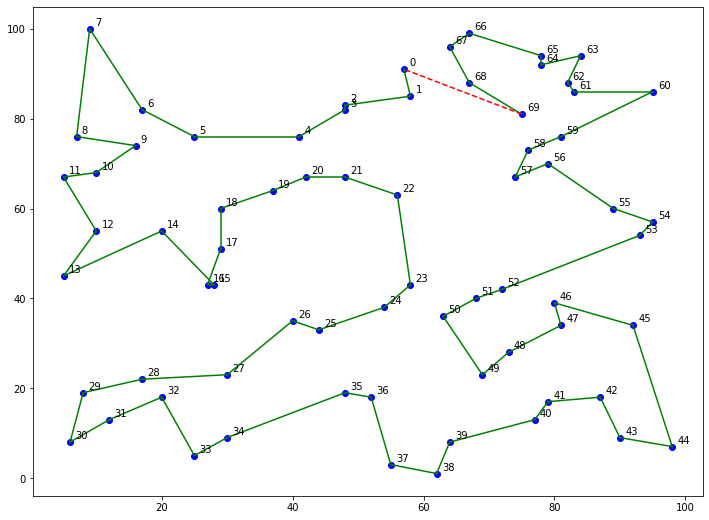

In [34]:
#Iterated Local Search Template
#multiple runs of Hill Climbing with intelligent initial conditions


#random intial solution of size 70
tour = np.arange(70)
np.random.shuffle(tour)

##################################################################
#objective function
objective = SimpleTSPObjective(matrix)
objective = OptimisedSimpleTSPObjective(matrix)
###################################################################

#create the general hill climber with two opt swaps
localsearch = HillClimber(objective, tour, 
                          TweakTwoOpt(),
                          maximisation=False)

####################################################################
#OPTIONS FOR UPDATING HOMEBASE
#UNCOMMENT THE OPTION YOU WOULD LIKE TO USE.

homebase_accept = EpsilonGreedyHomeBase(epsilon=0.3) #epsilon greedy 
#homebase_accept = HigherQualityHomeBase() #greedy method
#homebase_accept = RandomHomeBase() # random walk
#homebase_accept = AnnealingEpsilonGreedyHomeBase(maxiter_per_temp=20,
#                                                 verbose=True)  
####################################################################


####################################################################
#OPTIONS FOR PERTURBING HOMEBASE (medium to large tweak to homebase)
#UNCOMMENT THE OPTION YOU WOULD LIKE TO USE.

perturb = DoubleBridgePertubation() #no memory
#perturb =  TabuDoubleBridgeTweak(tabu_size=10, init_solution=tour) #with tabu
######################################################################

#create the ILS solver
#set verbose=False to suppress output of each iteration.
solver = IteratedLocalSearch(localsearch, 
                             accept=homebase_accept,
                             perturb=perturb,
                             verbose=True)

######################################################################
# NO. ITERATIONS OF ILS.
# This is a good parameter to experiment with.  Try more than 30.
n = 30
######################################################################

print(f"\nRunning {n} iterations...")
solver.run(n)

print("\n** ILS RESULTS ***")
print("best cost:\t{0}".format(solver.best_cost))
print("best solution:")
print(solver.best_solutions[0])
fig, ax = plot_tour(solver.best_solutions[0], cities, figsize=(12,9))

# Optional Exercise 8: Good solutions

**Task:**
* The tours below represent 'good', but not optimal solutions to the st70 problem.   
* Can you improve on them?  Either by using them as initial solutions in a hill-climbing / iterated local search algorithm or by tuning an evolutionary strategy?
* If you beat them then do tell!

**Hints**
* You can see the cost of each tour by calling `objective.evaluate()`

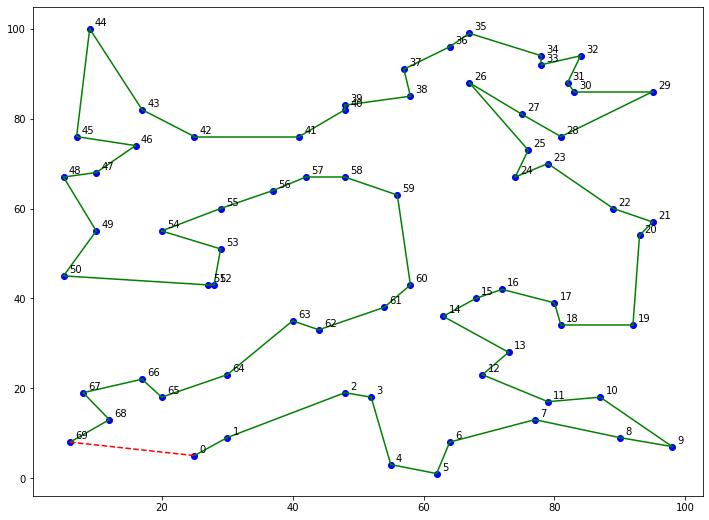

In [35]:
# cost = 688

objective = SimpleTSPObjective(matrix)

tour1 = np.array([45, 26, 67, 43, 29, 19, 13, 27, 48, 54, 25,  7,  2, 31, 41, 17,  3,
        1,  6, 18, 23, 14, 56, 62, 65, 21, 22, 37, 58, 34, 68, 30, 69, 12,
       28, 35,  0, 15, 46, 36, 57, 49, 50, 64, 63, 10, 55, 66, 47, 53, 61,
       33, 20, 11, 32, 59, 51,  9,  4, 52,  5, 40, 42, 16,  8, 39, 60, 38,
       44, 24])
                  
objective.evaluate(tour1)
fig, ax = plot_tour(tour1, cities, figsize=(12,9))

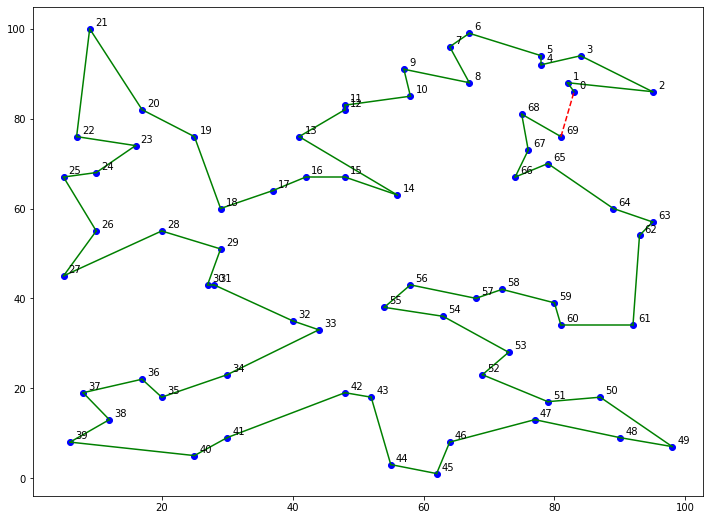

In [36]:
#cost = 683

tour2 = np.array([68, 30, 34, 69, 12, 28, 35,  0, 22, 15, 46, 36, 57, 49, 52,  4,  9,
       51, 59, 50, 64, 63, 10, 55, 66, 47, 53, 61, 32, 11, 33, 20, 16, 42,
        8, 39, 60, 38, 44, 24, 45, 26, 67, 43, 29, 19, 13, 27, 48, 54, 25,
        7,  2, 31, 41, 40,  5, 17,  3,  1,  6, 18, 23, 14, 56, 62, 65, 21,
       37, 58])

objective.evaluate(tour2)
fig, ax = plot_tour(tour2, cities, figsize=(12,9))

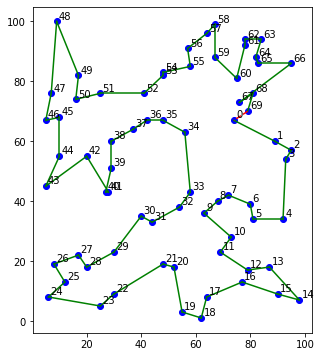

In [53]:
#cost = 686
tour3 = np.array([65, 56, 14, 23, 18,  6,  1,  3, 17, 41, 31,  2,  7, 25, 54, 48, 27,
       13, 19, 29, 43, 67, 26, 45, 24, 44, 38, 60, 39,  8, 16, 42, 40,  5,
       52,  4,  9, 51, 59, 11, 33, 20, 32, 61, 53, 66, 47, 10, 63, 64, 55,
       50, 49, 57, 36, 46, 15,  0, 35, 22, 37, 12, 28, 69, 30, 68, 34, 21,
       58, 62])
       
objective.evaluate(tour3)
fig, ax = plot_tour(tour3, cities, figsize=(12,6))

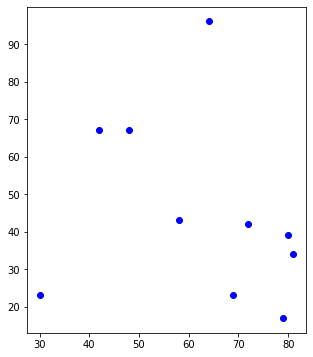

In [55]:
tour_length = 10
fig, ax = plt.subplots(1, 1, figsize=(5,6))


#plot points
ax.plot(cities[:tour_length][:, 0],
        cities[:tour_length][:, 1],'bo')

fig.savefig('points.png', bbox_inches='tight', dpi=150)